# Loading Packages and Data

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [3]:
directory = './ANALYTICS'
r = []
for root, dirs, files in os.walk(directory):
        for name in files:
            if name not in ['.DS_Store', 'Example.csv', 'Product.parquet.gzip']:
                r.append(os.path.join(root, name))
                
sales = pd.concat((pd.read_parquet(f) for f in r), ignore_index=True)

In [4]:
prod_path = './ANALYTICS/Product.parquet.gzip'
prods = pd.read_parquet(prod_path)

# Data Pre-Processing

In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14569473 entries, 0 to 14569472
Data columns (total 20 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id_customer       object 
 1   enrollement_date  object 
 2   postcode          object 
 3   city              object 
 4   country           object 
 5   order_date        object 
 6   id_order          object 
 7   id_order_detail   object 
 8   id_sale           object 
 9   id_brand          object 
 10  product_id        object 
 11  product_quantity  float64
 12  base_price        float64
 13  unit_price_TTC    float64
 14  discount_name     object 
 15  discount_value    float64
 16  campaign          object 
 17  MULTI             object 
 18  univers_final     object 
 19  anonymized_id     object 
dtypes: float64(4), object(16)
memory usage: 2.2+ GB


In [9]:
import pandas as pd

# Define a function to remove punctuation from a string value
def remove_punctuation(value):
    if value.endswith('.0'):
        return value[:-2]
    elif value.endswith(',0'):
        return value[:-2]
    else:
        return value

# Convert id_brand column to string, remove punctuation, and convert to integer
sales['id_brand'] = sales.id_brand.astype('string')
sales['id_brand'] = sales['id_brand'].apply(remove_punctuation)
sales['id_brand'] = sales['id_brand'].astype('int')

# Convert enrollement_date and order_date columns to datetime
date_cols = ['enrollement_date', 'order_date']
sales[date_cols] = sales[date_cols].apply(pd.to_datetime)

# Convert id_sale column to string
sales['id_sale'] = sales['id_sale'].astype('str')

# Calculate final_price as unit_price_TTC minus discount_value, and filter out rows where final_price, unit_price_TTC, or product_quantity is less than or equal to 0
sales['final_price'] = sales['unit_price_TTC'] - sales['discount_value']
sales = sales[~(sales['final_price'] <= 0)]
sales = sales[~(sales['unit_price_TTC'] <= 0)]
sales = sales[~(sales['product_quantity'] <= 0)]

# Calculate revenue as product_quantity times final_price, and add order_year and order_month columns based on the order_date column
sales['rev'] = sales['product_quantity'] * sales['final_price']
sales['order_year'] = sales['order_date'].dt.year
sales['order_month'] = sales['order_date'].dt.month

# Investigating some anomalies in the data

In [461]:
# splitting the dataframe into those with id_sale of small vs. large length
small_id = sales[sales["id_sale"].apply(lambda x: len(x) < 6)]
big_id = sales[sales['id_sale'].apply(lambda x: len(x) >= 6)]

<AxesSubplot: xlabel='order_date'>

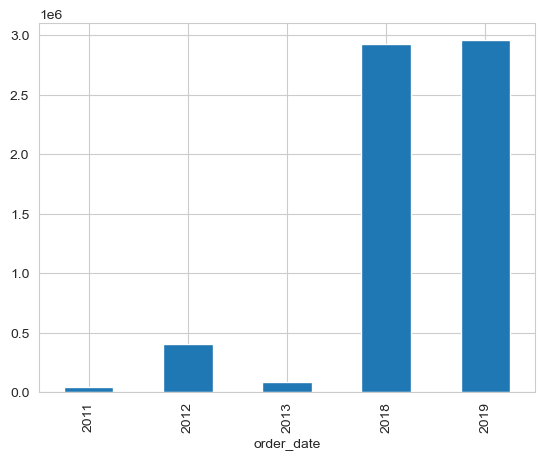

In [464]:
small_id.groupby(small_id["order_date"].dt.year).id_customer.count().plot(kind="bar")

<AxesSubplot: xlabel='order_date'>

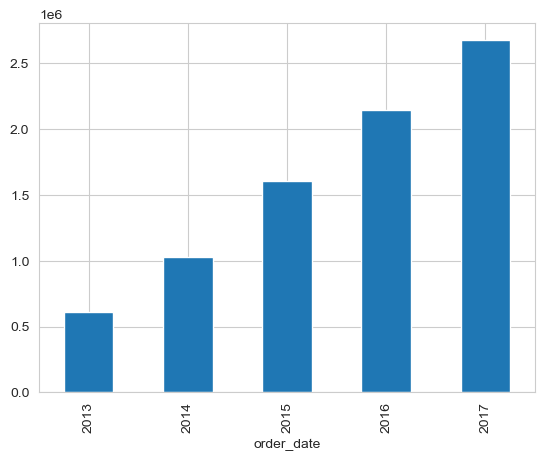

In [465]:
big_id.groupby(big_id["order_date"].dt.year).id_customer.count().plot(kind="bar")

It appears that midway through 2013, the company changed how it was collecting the 'id_sale' column and then it reverted back to the original format in 2018

### Additional Observation: Products that appear in the "Products" table are only those that were ordered after 2018. Therefore, less focus to be placed on the products table as it significantly reduces the scope of analysis

# Calculation of key statistics

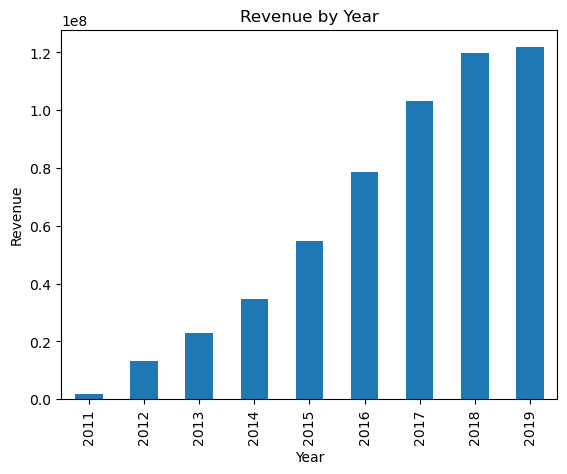

In [10]:
# Calculate revenue for each sale and add columns for year and month
sales['rev'] = sales['product_quantity'] * sales['unit_price_TTC']
sales['order_year'] = sales['order_date'].dt.year
sales['order_month'] = sales['order_date'].dt.month

# Group sales by year and sum revenue for each year
df_by_year = sales.groupby('order_year')['rev'].sum()

# Create a bar plot to visualize revenue by year
df_by_year.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.title('Revenue by Year')
plt.show()

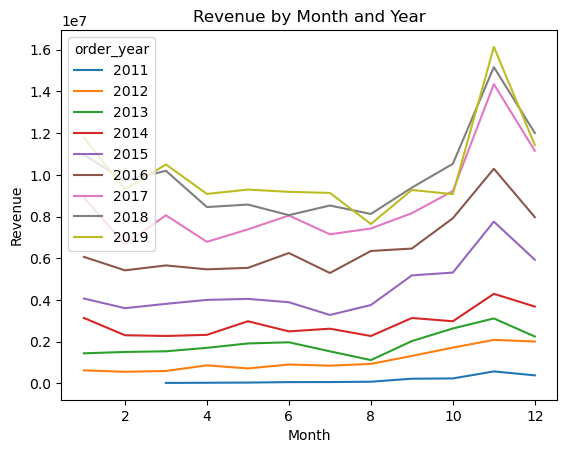

In [87]:
grouped = sales.groupby(['order_year', 'order_month'])['rev'].sum()

# unstack the grouped DataFrame so that each year becomes a separate column
grouped = grouped.unstack(level=0)

# create the line chart
grouped.plot(kind='line', legend=True)

# set the chart title and axis labels
plt.title('Revenue by Month and Year')
plt.xlabel('Month')
plt.ylabel('Revenue')

# display the chart
plt.show()

# Customer Data Exploration

## Pareto Chart

In [361]:
# Group sales by customer ID and calculate the sum of revenue for each customer
cr = sales.groupby('id_customer')['rev'].sum().reset_index()

# Rename columns to be more descriptive
cr.columns = ['id_customer', 'total_rev']

# Sort customers by their total revenue in descending order
cr = cr.sort_values(ascending=False, by='total_rev')

# Calculate cumulative revenue as a percentage of total revenue, and add a new column to the dataframe
cr['cum_rev'] = cr['total_rev'].cumsum() / cr['total_rev'].sum() * 100

# Reset the index of the dataframe and drop the original index
cr.reset_index(drop=True, inplace=True)

# Calculate the running percentage of customers, based on their position in the sorted dataframe
cr['running_percentage'] = (cr.index + 1) / cr.index.max() * 100

<AxesSubplot: title={'center': 'Percentage of Revenue from Top % of Customers'}, xlabel='running_percentage'>

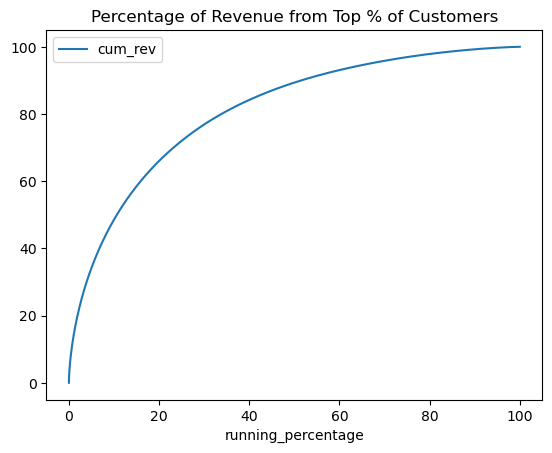

In [366]:
cr.plot.line(x = 'running_percentage', y = 'cum_rev', title = 'Percentage of Revenue from Top % of Customers')

## Contribution from new vs. existing customers

In [19]:
sales['en_year'] = sales['enrollement_date'].dt.year
sales['en_month'] = sales['enrollement_date'].dt.month
sales['new_yr'] = sales['en_year'] == sales['order_year']

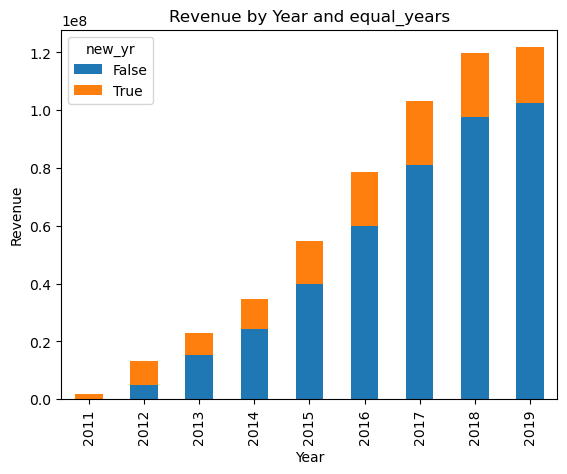

In [23]:
grouped_df = sales.groupby(['order_year', 'new_yr'])['rev'].sum().reset_index()

# Pivot the dataframe to make it easier to plot
pivot_df = grouped_df.pivot(index='order_year', columns='new_yr', values='rev')

# Create a bar chart
pivot_df.plot(kind='bar', stacked=True)
plt.title('Revenue by Year and equal_years')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.show()

In [24]:
df_pct = (sales.groupby(['order_year', 'new_yr'])['rev'].sum()/sales.groupby(['order_year'])['rev'].sum())

<AxesSubplot: title={'center': 'Percentage of Revenue from New vs. Existing Customers'}, xlabel='order_year'>

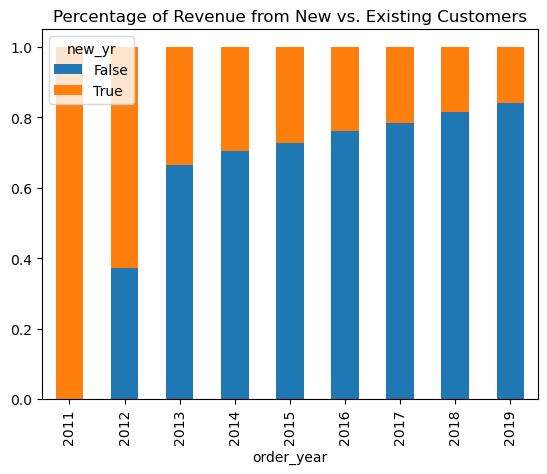

In [84]:
df_pct.unstack().plot.bar(stacked=True, title = 'Percentage of Revenue from New vs. Existing Customers')

# Now, exploration of some of the categories

In [25]:
# Count the number of unique product categories purchased by each customer, and add a new column to the sales dataframe
sales['num_purchase_categories'] = sales.groupby('id_customer')['univers_final'].nunique()

# Group sales by customer ID, count the number of unique product categories purchased by each customer, and reset the index
num_purchase_categories = sales.groupby('id_customer')['univers_final'].nunique().reset_index()

# Rename the 'univers_final' column to 'num_purchase_categories' for clarity
num_purchase_categories = num_purchase_categories.rename(columns={'univers_final': 'num_purchase_categories'})

# Merge the num_purchase_categories dataframe with the sales dataframe, based on customer ID
# This adds a new column to the sales dataframe that indicates the number of unique product categories purchased by each customer
sales = sales.merge(num_purchase_categories, on='id_customer', how='left')

<AxesSubplot: >

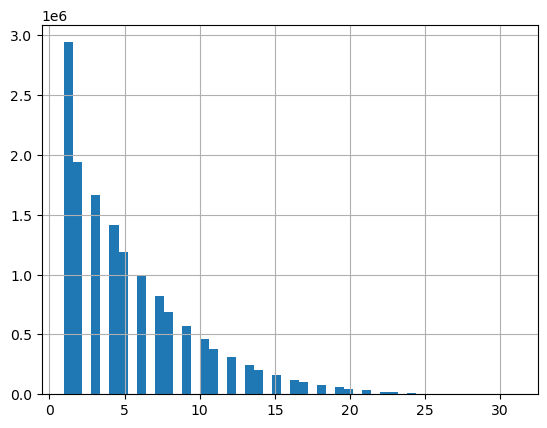

In [27]:
sales.num_purchase_categories_y.hist(bins = 50)

# Finally, exploration of the products which are listed in "Products" table

In [32]:
merged = pd.merge(sales, prods, left_on='product_id', right_on='id_product', how='inner')
merged['PVC'] = merged['PVC'].str.replace(',', '.').astype('float64')
merged['percent_disc'] = (merged['unit_price_TTC'] - merged['PVC']) / merged['PVC']

<AxesSubplot: >

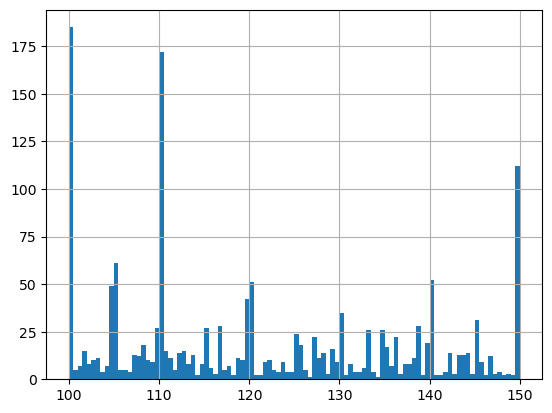

In [83]:
sales.discount_value.hist(bins = 100, range = [100, 150])

In [66]:
merged['price_diff'] = merged['Prix XXX'] - merged['unit_price_TTC']

<AxesSubplot: >

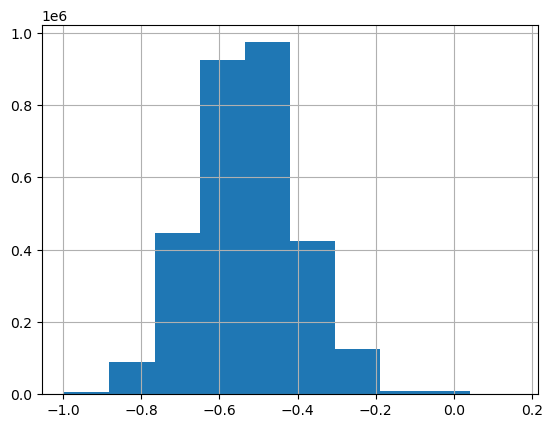

In [79]:
merged.percent_disc.hist()

Here, we see that on average, products are priced at about half of their PVC value

Text(0, 0.5, 'Percentage Discounted')

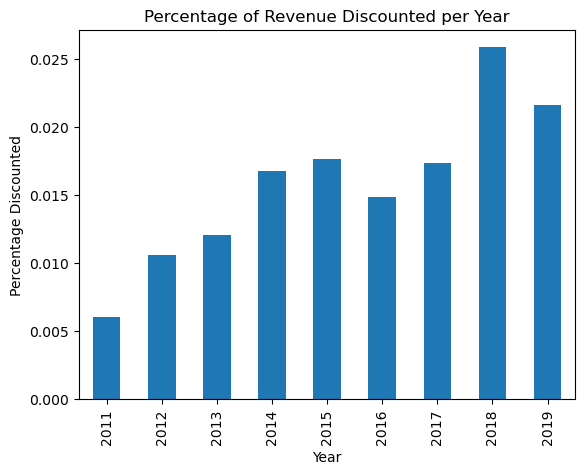

In [88]:
revenue_by_year = sales.groupby(sales['order_date'].dt.year)['price_before_disc'].sum()
discount_by_year = sales.groupby(sales['order_date'].dt.year)['discount_value'].sum()
new = pd.concat([revenue_by_year, discount_by_year], axis = 1)

new['disc_perc'] = new['discount_value'] / new['price_before_disc']


# create a bar chart
new.disc_perc.plot(kind='bar')

# set chart title and axis labels
plt.title('Percentage of Revenue Discounted per Year')
plt.xlabel('Year')
plt.ylabel('Percentage Discounted')

# display the chart

In general, discounts have gone up, but in 2019, they dropped, possibly explaining our difference in sales

## Here, we observe the amount of new and distinct products each year, which indicates how quickly products move off the shelves

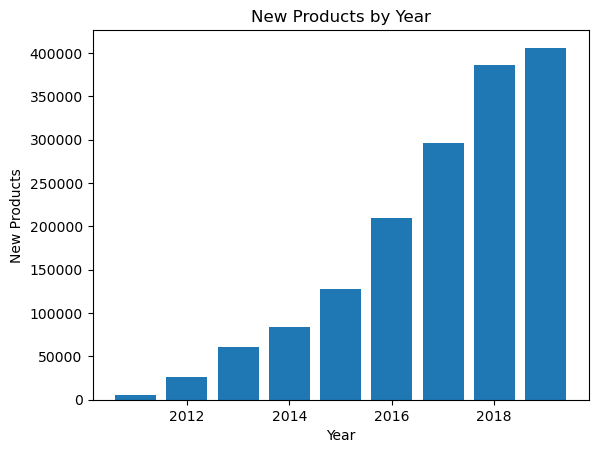

In [91]:
new_products_by_year = sales.groupby(sales['order_date'].dt.year)['new_product'].sum()

# create a bar chart of new products by year
plt.bar(new_products_by_year.index, new_products_by_year.values)
plt.xlabel('Year')
plt.ylabel('New Products')
plt.title('New Products by Year')
plt.show()

Text(0.5, 1.0, 'New Products by Year')

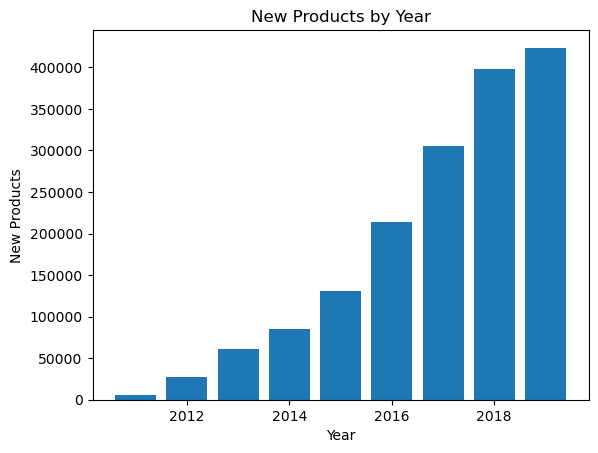

In [94]:
distinct_products_by_year = sales.groupby(sales['order_date'].dt.year)['product_id'].nunique()

# print the number of distinct products sold in each year
plt.bar(distinct_products_by_year.index, distinct_products_by_year.values)
plt.xlabel('Year')
plt.ylabel('New Products')
plt.title('New Products by Year')

In [121]:
sales.groupby('order_year').new_product.sum()

order_year
2011      5200
2012     26726
2013     61126
2014     84035
2015    128291
2016    209736
2017    296480
2018    386483
2019    406183
Name: new_product, dtype: int64

## This leads us to look into the product lifecycle and the various statistics related to shelf life

In [137]:
sales['min'] = sales.groupby('product_id').order_date.transform('min')

In [139]:
sales['max'] = sales.groupby('product_id').order_date.transform('max')

In [140]:
sales['shelf_life'] = sales['max'] - sales['min']

In [143]:
sales['number_sold'] = sales.groupby('product_id').order_date.transform('count')

<AxesSubplot: >

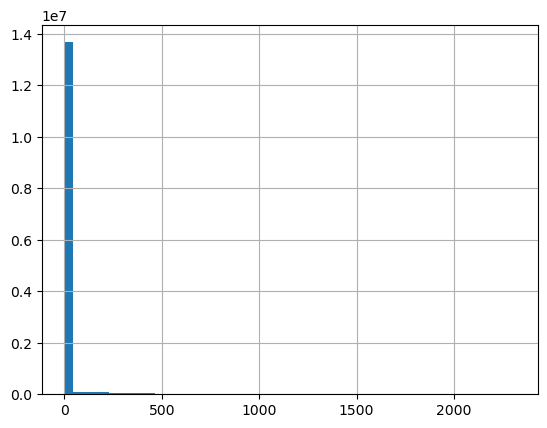

In [174]:
sales.shelf_life.dt.days.hist(bins = 50)

In [165]:
merged = pd.merge(sales, prods, left_on='product_id', right_on='id_product', how='inner')
merged['PVC'] = merged['PVC'].str.replace(',', '.').astype('float64')
merged['percent_disc'] = (merged['unit_price_TTC'] - merged['PVC']) / merged['PVC']

In [154]:
merged['shelf_life'] = merged.shelf_life.dt.days

In [169]:
merged['number_sold'] = merged['number_sold'].astype('float64')

In [186]:
sales[sales['order_year'] == 2011].sort_values(by = 'order_date').head()

,id_customer,enrollement_date,postcode,city,country,order_date,id_order,id_order_detail,id_sale,id_brand,product_id,product_quantity,base_price,unit_price_TTC,discount_name,discount_value,campaign,MULTI,univers_final,anonymized_id,final_price,rev,order_year,order_month,en_year,en_month,new_yr,num_purchase_categories_y,price_before_disc,new_product,min,max,shelf_life,number_sold,purchase_by_cust
12304480,01f78be6f7,2011-03-02,86000,POITIERS,France,2011-03-04,9bf31c7ff0,1f0e3dad99,10541,2347,6c8349cc72,2.0,18.39,176.70,None,0.0,0,Mono,Other,1f0e3dad99,176.70,353.40,2011,3,2011,3,True,1,353.40,True,2011-03-04,2011-03-10,6 days,9,2
12304473,e22312179b,2011-03-04,78480,VERNEUIL SUR SEINE,France,2011-03-04,6512bd43d9,c20ad4d76f,10541,2303,3416a75f4c,2.0,13.38,29.90,None,0.0,0,Mono,Other,c20ad4d76f,29.90,59.80,2011,3,2011,3,True,5,59.80,False,2011-03-04,2011-03-10,6 days,5,41
12304474,6364d3f0f4,2011-02-22,81100,CASTRES,France,2011-03-04,c20ad4d76f,c51ce410c1,10541,2347,6c8349cc72,1.0,18.39,176.70,None,0.0,0,Mono,Other,c51ce410c1,176.70,176.70,2011,3,2011,2,True,2,176.70,False,2011-03-04,2011-03-10,6 days,9,48
12304487,e6d8545daa,2011-03-04,33850,leognan,France,2011-03-04,6f4922f455,4e732ced34,10541,2303,6ea9ab1baa,1.0,13.38,37.38,None,0.0,0,Mono,Other,4e732ced34,37.38,37.38,2011,3,2011,3,True,3,37.38,False,2011-03-04,2011-03-10,6 days,9,17
12304486,e6d8545daa,2011-03-04,33850,leognan,France,2011-03-04,6f4922f455,8e296a067a,10541,2303,17e62166fc,1.0,19.23,20.80,None,0.0,0,Mono,Other,8e296a067a,20.80,20.80,2011,3,2011,3,True,3,20.80,True,2011-03-04,2011-03-06,2 days,2,17


In [188]:
sales.groupby('order_year').rev.sum()

order_year
2011    1.734053e+06
2012    1.319082e+07
2013    2.276818e+07
2014    3.451865e+07
2015    5.465494e+07
2016    7.868958e+07
2017    1.033059e+08
2018    1.196958e+08
2019    1.218207e+08
Name: rev, dtype: float64

# Data Generation for Tableau

## Average Order Value:

In [201]:
aov_m = sales.groupby(['order_year', 'order_month']).rev.mean().reset_index()

In [203]:
aov_y = sales.groupby('order_year').rev.mean().reset_index()

In [210]:
new = aov_m.merge(aov_y, left_on='order_year', right_on='order_year')

In [211]:
new.head()

,order_year,order_month,rev_x,rev_y
0,2011,3,57.114606,38.44396
1,2011,4,26.088047,38.44396
2,2011,5,29.874915,38.44396
3,2011,6,35.457603,38.44396
4,2011,7,42.482281,38.44396


In [214]:
new = new.rename(columns={"rev_x": "Monthly Average Order Value", "rev_y": "Yearly Average Order Value"})

In [218]:
new.to_csv('avg_ord_val.csv', index=False)

## Shelf Life

In [246]:
sales['avg_days'] = sales['shelf_life'] / sales['number_sold']

In [432]:
shelf_y = sales.groupby(['order_year', 'univers_final']).avg_days.mean()

In [433]:
shelf_t = sales.groupby('univers_final').shelf_life.mean()

In [434]:
shelf_y = shelf_y.to_frame().reset_index()

In [435]:
shelf_y = shelf_y[shelf_y['order_year'] >= 2016]

In [436]:
cats = sales[sales['order_year'] >= 2016].univers_final.value_counts()

In [438]:
category_list = list(cats[cats < 400000].index)

In [440]:
sales['new_cats'] = sales['univers_final'].apply(lambda x: 'Other' if x in category_list else x)

In [441]:
shelf_y = sales.groupby(['order_year', 'new_cats']).avg_days.mean()
shelf_y = shelf_y.to_frame().reset_index()
shelf_y = shelf_y[shelf_y['order_year'] >= 2016]

In [442]:
shelf_y.head()

,order_year,new_cats,avg_days
13,2016,"Arts, Crafts & Sewing",0.245603
14,2016,Bathroom Accessories,0.394663
15,2016,Electronics,0.289242
16,2016,Other,2.112520
17,2016,Software,84.384615


In [444]:
shelf_y = shelf_y.sort_values(by='order_year')

# group the data by category
grouped = shelf_y.groupby('new_cats')

# calculate the percentage change in avg_days
growth_rate = grouped['avg_days'].pct_change()

# add the growth_rate column to the dataframe
shelf_y['growth_rate'] = growth_rate

In [448]:
shelf_y[~(shelf_y['new_cats'] == 'Software')]

,order_year,new_cats,avg_days,growth_rate
13,2016,"Arts, Crafts & Sewing",0.245603,NaN
14,2016,Bathroom Accessories,0.394663,NaN
15,2016,Electronics,0.289242,NaN
16,2016,Other,2.112520,NaN
18,2016,Toys & Games,0.409980,NaN
19,2016,Video Games,0.333830,NaN
29,2017,Video Games,0.466820,0.398375
28,2017,Toys & Games,0.585824,0.428908
26,2017,Rugs,0.431781,NaN
25,2017,Other,2.987512,0.414194


Text(0.5, 1.0, 'Growth Rate of Avg Days by Category')

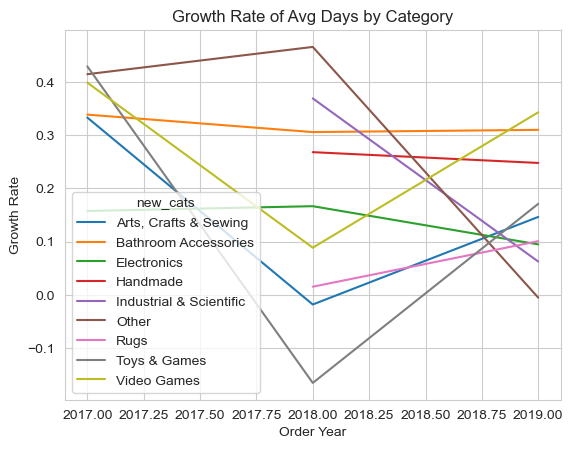

In [449]:
plot_data = shelf_y[~(shelf_y['new_cats'] == 'Software')].pivot(index='order_year', columns='new_cats', values='growth_rate')

# plot the data
plot_data.plot(kind='line')

# add axis labels and title
plt.xlabel('Order Year')
plt.ylabel('Growth Rate')
plt.title('Growth Rate of Avg Days by Category')

In [451]:
shelf_y = shelf_y[~(shelf_y['new_cats'] == 'Software')]

In [452]:
shelf_y.to_csv('shelf_life.csv', index = False)

Text(0.5, 1.0, 'Avg Days by Category and Year')

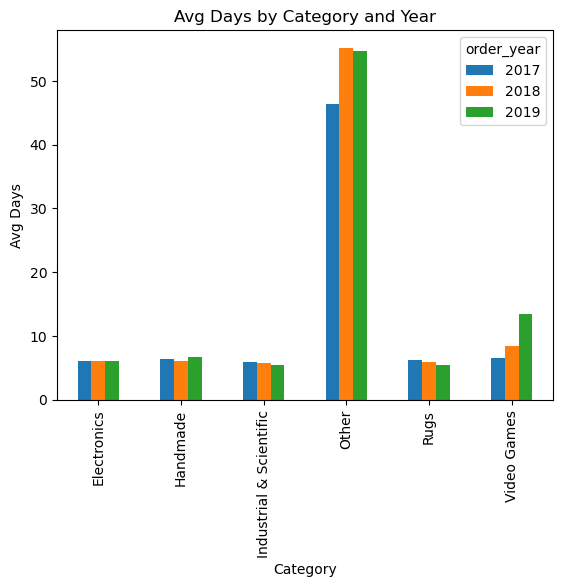

In [415]:
pivot_df = shelf_y.pivot(index='new_cats', columns='order_year', values='shelf_life')

# plot the bar chart
pivot_df.plot(kind='bar')

# add labels and title
plt.xlabel('Category')
plt.ylabel('Avg Days')
plt.title('Avg Days by Category and Year')

## Customer Retention

In [303]:
cust = sales.groupby(['order_year', 'new_yr']).id_customer.nunique().to_frame().reset_index()

In [305]:
cust['new_yr'] = cust['new_yr'].apply(lambda x: 'New' if x == True else 'Existing')

In [309]:
pivot_df = cust.pivot(index='order_year', columns='new_yr', values='id_customer')

Text(0.5, 1.0, 'Unique Customers by Customer Type')

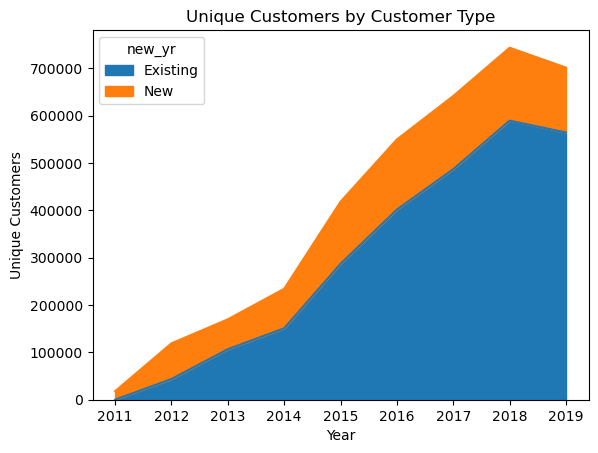

In [312]:
pivot_df.plot(kind='area')

# add labels and title
plt.xlabel('Year')
plt.ylabel('Unique Customers')
plt.title('Unique Customers by Customer Type')

In [313]:
cust.to_csv('customers.csv', index = False)

## Product-Level Analysis

In [316]:
merged = pd.merge(sales, prods, left_on='product_id', right_on='id_product', how='inner')
merged['PVC'] = merged['PVC'].str.replace(',', '.').astype('float64')
merged['percent_disc'] = (merged['unit_price_TTC'] - (merged['discount_value'] / merged['product_quantity']) - merged['PVC']) / merged['PVC']

In [318]:
merged = merged[merged['order_year'] == 2019]

In [322]:
vg = merged[merged['new_cats'] == 'Video Games']

In [325]:
vg_per = vg.groupby('product_id').percent_disc.mean()
vg_per = vg_per.to_frame().reset_index()

vg_shelf = vg.groupby('product_id').shelf_life.mean()
vg_shelf = vg_shelf.to_frame().reset_index()

vg_num = vg.groupby('product_id').number_sold.mean()
vg_num = vg_num.to_frame().reset_index()

In [327]:
vg_num
vg = vg_per.merge(vg_shelf, left_on='product_id', right_on='product_id')
vg = vg.merge(vg_num, left_on='product_id', right_on='product_id')

       product_id  percent_disc  shelf_life  number_sold
0      0000f04449     -0.872952         7.0         11.0
1      0001539fee     -0.430000         0.0          2.0
2      000374c660     -0.518474         2.0          2.0
3      0003d657a3     -0.501667         1.0          2.0
4      000789901d     -0.668389         7.0         18.0
...           ...           ...         ...          ...
43677  fffacaaea0     -0.558173         4.0          5.0
43678  fffb6ecbaf     -0.616667         0.0          1.0
43679  fffbe6c64f     -0.347000         2.0          4.0
43680  fffca9ed91     -0.600500         5.0          6.0
43681  fffd43c6aa     -0.500250         1.0          2.0

[43682 rows x 4 columns]


In [341]:
vg.head(20).to_csv('vg.csv', index = False)

## External Market

In [376]:
mkt = pd.read_csv('/Users/jacksonburke52/Downloads/statistic_id432762_annual-revenue-of-the-furniture-market-in-france-2004-2021.csv')

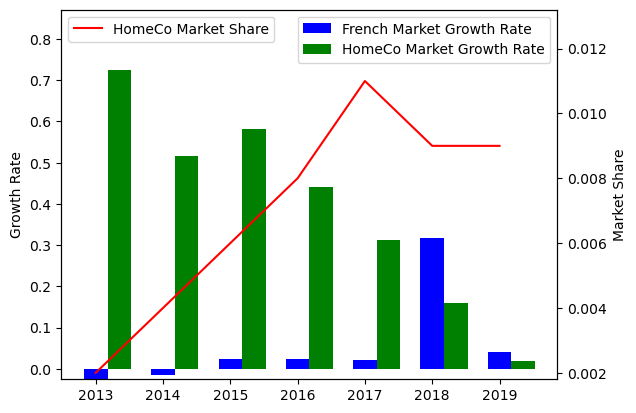

In [401]:
bar_width = 0.35

fig, ax1 = plt.subplots()

# Create the first set of bar charts
bar1 = ax1.bar(df['Year'], df['French Market Growth Rate'], width=bar_width, color='blue', label='French Market Growth Rate')
bar2 = ax1.bar(df['Year'] + bar_width, df['HomeCo Growth Rate'], width=bar_width, color='green', label='HomeCo Growth Rate')

# Set the y-axis label and limits for the bar chart
ax1.set_ylabel('Growth Rate')
ax1.set_ylim([min(df['French Market Growth Rate'].min(), df['HomeCo Growth Rate'].min()) * .9, max(df['French Market Growth Rate'].max(), df['HomeCo Growth Rate'].max()) * 1.2])

# Create the second axis object and plot the line chart
ax2 = ax1.twinx()
line1 = ax2.plot(df['Year'], df['HomeCo Market Share'], color='red', label='HomeCo Market Share')

# Set the y-axis label and limits for the line chart
ax2.set_ylabel('Market Share')
ax2.set_ylim([df['HomeCo Market Share'].min() * .9, df['HomeCo Market Share'].max() * 1.2])

# Combine the legends from both charts and show the plot
bars = bar1 + bar2
labels = ['French Market Growth Rate', 'HomeCo Market Growth Rate']
ax1.legend([bar1, bar2], labels, loc='best')
label = ['HomeCo Market Share']
ax2.legend(line1, label, loc='upper left')


# Shift x-axis labels to the center of the bars
ax1.set_xticks(df['Year'])
ax1.set_xticklabels(df['Year'])

# Show the plot
plt.show()